# Imports and Variables

In [161]:
import numpy as np
import seaborn as sns
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [ ]:
df = pd.read_csv("Data/processed/model_metrics.csv")
df = df[(df["network"] == "EfficientNetV2B0_20_epochs")]

def parse_confusion_matrix(x):
    if isinstance(x, str):
        cleaned = re.sub(r"[^0-9\-]+", " ", x)
        nums = [int(n) for n in cleaned.split() if n.strip() != ""]
        size = int(len(nums)**0.5)
        return np.array(nums).reshape(size, size)
    else:
        return np.array(x)

df["confusion_matrix"] = df["confusion_matrix"].apply(parse_confusion_matrix)

color_maps = {
    "microscope": "Reds",
    "phone": "Purples",
    "comparison": "Oranges",
    "fresh": "Greens",
    "dried": "Greys",
    "all": "Blues"
}

color_palette = {
    "microscope": "#d62728",
    "phone": "#9467bd",
    "comparison": "#ff7f0e",
    "fresh": "#2ca02c",
    "dried": "#7f7f7f",
    "all": "#1f77b4"
}

# Device comparison

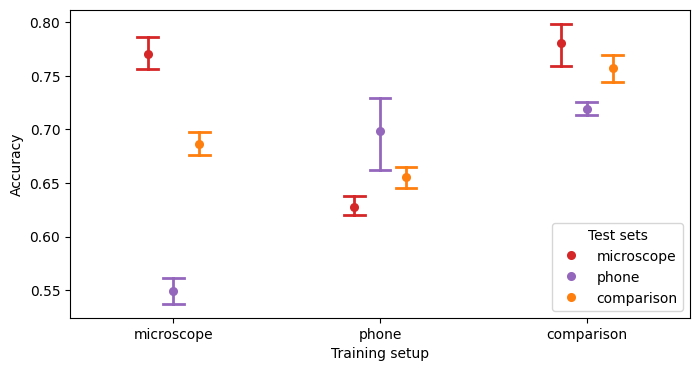

In [195]:
metrics = ["accuracy"]

relevant_model = ["microscope", "phone", "comparison"]
relevant_evals = ["microscope", "phone", "comparison"]


filtered = df[
(df["subset_name"].isin(relevant_model)) &
(df["eval_subset"].isin(relevant_evals))
]

for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.pointplot(
        data=filtered,
        x="subset_name",
        y=metric,
        hue="eval_subset",
        palette=color_palette,
        errorbar=('ci', 95),
        capsize=0.1,
        estimator="mean",
        linestyle='none',
        dodge=0.25,
        linewidth=2
    )
    
    plt.ylabel(metric.capitalize())
    plt.xlabel("Training setup")
    plt.legend(title="Test sets")
    plt.show()

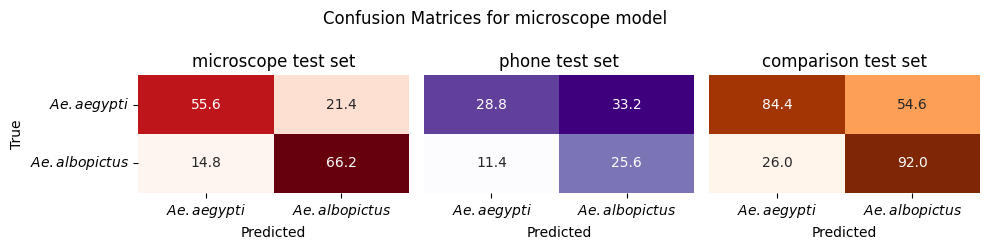

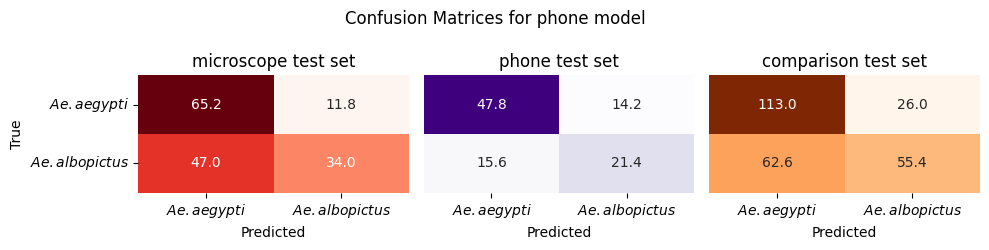

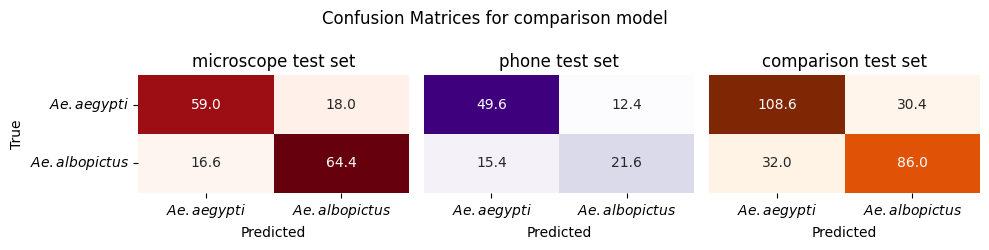

In [ ]:
cm_results = {}

relevant_model = ["microscope", "phone", "comparison"]
relevant_evals = ["microscope", "phone", "comparison"]


filtered = df[
(df["subset_name"].isin(relevant_model)) &
(df["eval_subset"].isin(relevant_evals))
]

for (subset, evalset), group in filtered.groupby(["subset_name", "eval_subset"]):
    matrices = np.stack(group["confusion_matrix"].values)
    mean_cm = matrices.mean(axis=0)
    cm_results[(subset, evalset)] = mean_cm

for subset in filtered["subset_name"].unique():
    fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))
    for i, evalset in enumerate(relevant_evals):
        cm = cm_results.get((subset, evalset))
        if cm is None:
            continue
        ax = axes[i]
        sns.heatmap(
            cm,
            annot=True,
            fmt=".1f",
            cmap=color_maps[evalset],
            cbar=False,
            xticklabels=["$Ae. aegypti$", "$Ae. albopictus$"],
            yticklabels=["$Ae. aegypti$", "$Ae. albopictus$"] if i == 0 else False,
            ax=ax
        )
        ax.set_title(f"{evalset} test set")
        ax.set_xlabel("Predicted")
        if i == 0:
            ax.set_ylabel("True")
        else:
            ax.set_ylabel("")
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
        if i == 0:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")
    plt.suptitle(f"Confusion Matrices for {subset} model")
    plt.tight_layout()
    plt.show()

In [ ]:
metrics = ["accuracy"]
relevant_model = ["microscope", "phone", "comparison"]
relevant_evals = ["microscope", "phone", "comparison"]

filtered = df[
    (df["subset_name"].isin(relevant_model)) &
    (df["eval_subset"].isin(relevant_evals))
]

summary_results = []
pairwise_results = []

for metric in metrics:
    for subset in relevant_model:
        subset_data = filtered[filtered["subset_name"] == subset]
        
        normal_flags = {}
        groups = {}
        normal_p = {}
        for evalset in relevant_evals:
            values = subset_data[subset_data["eval_subset"] == evalset][metric].dropna().values
            groups[evalset] = values
            if len(values) >= 3:
                stat, p = stats.shapiro(values)
                normal_flags[evalset] = p > 0.05                
            else:
                normal_flags[evalset] = False
            normal_p[evalset] = p
        
        all_normal = all(normal_flags.values())
        
        if all_normal:
            f_stat, p_overall = stats.f_oneway(*groups.values())
            test = "ANOVA"
        else:
            h_stat, p_overall = stats.kruskal(*groups.values())
            test = "Kruskal"
        
        for evalset, values in groups.items():
            n = len(values)
            mean = np.mean(values)
            sem = stats.sem(values) if n > 1 else 0
            ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=sem) if n > 1 else (mean, mean)
            plusminus = ci_high - mean
            summary_results.append({
                "metric": metric,
                "model": subset,
                "eval_subset": evalset,
                "n": n,
                "mean": mean,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "plusminus": plusminus,
                "normal_p": normal_p[evalset],
                "normal_dist": normal_flags[evalset],
                "test": test,
                "overall_p": p_overall,
                "significant_overall": p_overall < 0.05
            })
        
        for g1, g2 in combinations(relevant_evals, 2):
            v1, v2 = groups[g1], groups[g2]
            if all_normal:
                t_stat, p_value = stats.ttest_ind(v1, v2)
                pair_test = "T-test"
            else:
                u_stat, p_value = stats.mannwhitneyu(v1, v2, alternative="two-sided")
                pair_test = "WithneyU"
            pairwise_results.append({
                "metric": metric,
                "model": subset,
                "pair_test": pair_test,
                "pair": f"{g1} vs {g2}",
                "p_value": p_value,
                "significant_pair": p_value < 0.05,
                "normal_dist": all_normal
            })


summary_df = pd.DataFrame(summary_results)
pairwise_df = pd.DataFrame(pairwise_results)
summary_df

,metric,model,eval_subset,n,mean,ci_low,ci_high,plusminus,normal_p,normal_dist,test,overall_p,significant_overall
0,accuracy,microscope,microscope,5,0.770886,0.748382,0.793390,0.022504,0.679902,True,ANOVA,1.870018e-10,True
1,accuracy,microscope,phone,5,0.549495,0.530474,0.568516,0.019021,0.085693,True,ANOVA,1.870018e-10,True
2,accuracy,microscope,comparison,5,0.686381,0.668762,0.704001,0.017620,0.775241,True,ANOVA,1.870018e-10,True
3,accuracy,phone,microscope,5,0.627848,0.613790,0.641906,0.014058,0.045954,False,Kruskal,1.345414e-02,True
4,accuracy,phone,phone,5,0.698990,0.646974,0.751005,0.052016,0.390334,True,Kruskal,1.345414e-02,True
5,accuracy,phone,comparison,5,0.655253,0.638657,0.671849,0.016596,0.419497,True,Kruskal,1.345414e-02,True
6,accuracy,comparison,microscope,5,0.781013,0.748326,0.813699,0.032687,0.616909,True,ANOVA,7.738475e-04,True
7,accuracy,comparison,phone,5,0.719192,0.708698,0.729685,0.010493,0.314040,True,ANOVA,7.738475e-04,True
8,accuracy,comparison,comparison,5,0.757198,0.735973,0.778424,0.021225,0.664607,True,ANOVA,7.738475e-04,True


In [183]:
pairwise_df

,metric,subset_name,pair_test,pair,p_value,significant_pair,normal_dist
0,accuracy,microscope,T-test,microscope vs phone,2.924464e-08,True,True
1,accuracy,microscope,T-test,microscope vs comparison,3.625008e-05,True,True
2,accuracy,microscope,T-test,phone vs comparison,4.606516e-07,True,True
3,accuracy,phone,WithneyU,microscope vs phone,2.000819e-02,True,False
4,accuracy,phone,WithneyU,microscope vs comparison,3.389485e-02,True,False
5,accuracy,phone,WithneyU,phone vs comparison,1.424567e-01,False,False
6,accuracy,comparison,T-test,microscope vs phone,1.053077e-03,True,True
7,accuracy,comparison,T-test,microscope vs comparison,1.282272e-01,False,True
8,accuracy,comparison,T-test,phone vs comparison,2.120315e-03,True,True


# Drying comparison

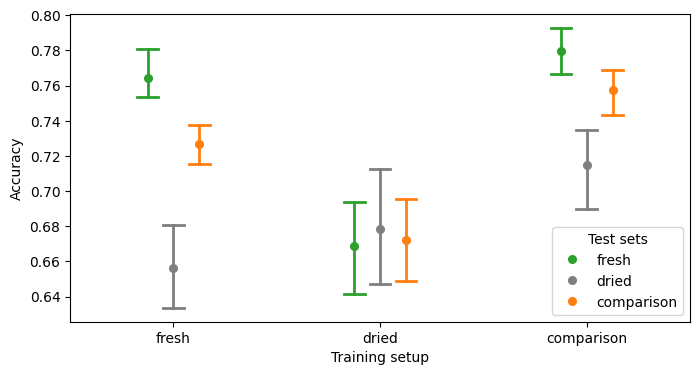

In [196]:
metrics = ["accuracy"]

relevant_subsets = ["fresh", "dried", "comparison"]
relevant_evals = ["fresh", "dried", "comparison"]


filtered = df[
(df["subset_name"].isin(relevant_subsets)) &
(df["eval_subset"].isin(relevant_evals))
]

for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.pointplot(
        data=filtered,
        x="subset_name",
        y=metric,
        hue="eval_subset",
        palette=color_palette,
        errorbar=('ci', 95),
        capsize=0.1,
        estimator="mean",
        linestyle='none',
        dodge=0.25,
        linewidth=2
    )
    plt.ylabel(metric.capitalize())
    plt.xlabel("Training setup")
    plt.legend(title="Test sets")
    plt.show()

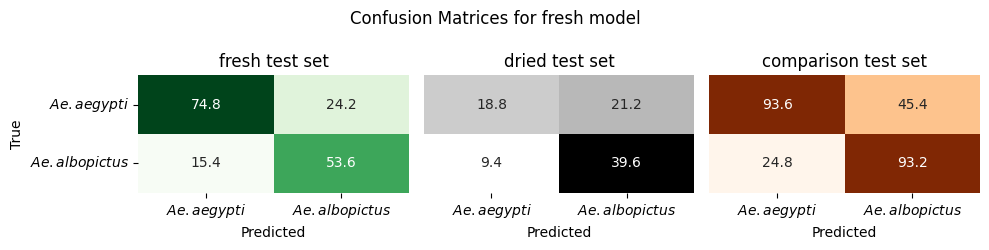

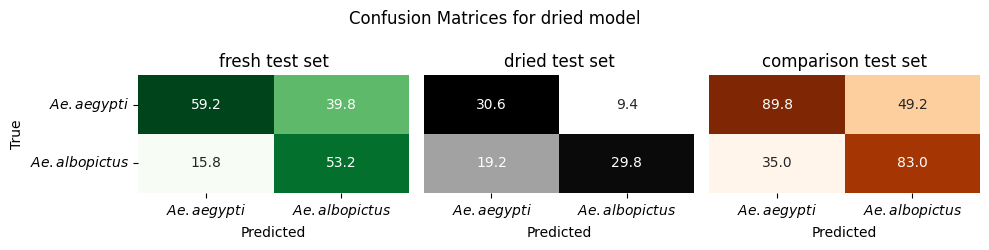

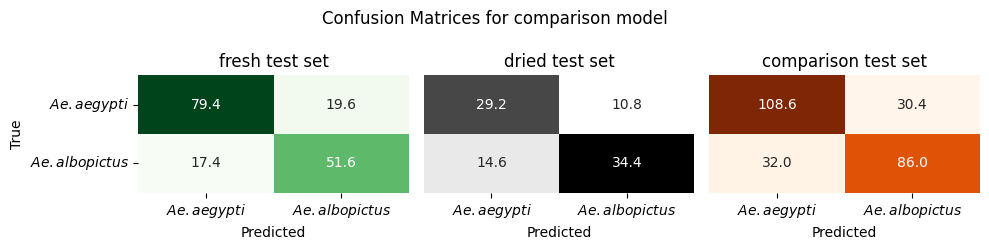

In [ ]:
cm_results = {}

relevant_model = ["fresh", "dried", "comparison"]
relevant_evals = ["fresh", "dried", "comparison"]


filtered = df[
(df["subset_name"].isin(relevant_model)) &
(df["eval_subset"].isin(relevant_evals))
]

for (subset, evalset), group in filtered.groupby(["subset_name", "eval_subset"]):
    matrices = np.stack(group["confusion_matrix"].values)
    mean_cm = matrices.mean(axis=0)
    cm_results[(subset, evalset)] = mean_cm

for subset in filtered["subset_name"].unique():
    fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))
    for i, evalset in enumerate(relevant_evals):
        cm = cm_results.get((subset, evalset))
        if cm is None:
            continue
        ax = axes[i]
        sns.heatmap(
            cm,
            annot=True,
            fmt=".1f",
            cmap=color_maps[evalset],
            cbar=False,
            xticklabels=["$Ae. aegypti$", "$Ae. albopictus$"],
            yticklabels=["$Ae. aegypti$", "$Ae. albopictus$"] if i == 0 else False,
            ax=ax
        )
        ax.set_title(f"{evalset} test set")
        ax.set_xlabel("Predicted")
        if i == 0:
            ax.set_ylabel("True")
        else:
            ax.set_ylabel("")
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
        if i == 0:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")
    plt.suptitle(f"Confusion Matrices for {subset} model")
    plt.tight_layout()
    plt.show()

In [ ]:
relevant_model = ["fresh", "dried", "comparison"]
relevant_evals = ["fresh", "dried", "comparison"]


filtered = df[
(df["subset_name"].isin(relevant_model)) &
(df["eval_subset"].isin(relevant_evals))
]

summary_results = []
pairwise_results = []

for metric in metrics:
    for subset in relevant_model:
        subset_data = filtered[filtered["subset_name"] == subset]
        
        normal_flags = {}
        groups = {}
        normal_p = {}
        for evalset in relevant_evals:
            values = subset_data[subset_data["eval_subset"] == evalset][metric].dropna().values
            groups[evalset] = values
            if len(values) >= 3:
                stat, p = stats.shapiro(values)
                normal_flags[evalset] = p > 0.05                
            else:
                normal_flags[evalset] = False
            normal_p[evalset] = p
        
        all_normal = all(normal_flags.values())
        
        if all_normal:
            f_stat, p_overall = stats.f_oneway(*groups.values())
            test = "ANOVA"
        else:
            h_stat, p_overall = stats.kruskal(*groups.values())
            test = "Kruskal"
        
        for evalset, values in groups.items():
            n = len(values)
            mean = np.mean(values)
            sem = stats.sem(values) if n > 1 else 0
            ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=sem) if n > 1 else (mean, mean)
            plusminus = ci_high - mean
            summary_results.append({
                "metric": metric,
                "model": subset,
                "eval_subset": evalset,
                "n": n,
                "mean": mean,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "plusminus": plusminus,
                "normal_p": normal_p[evalset],
                "normal_dist": normal_flags[evalset],
                "test": test,
                "overall_p": p_overall,
                "significant_overall": p_overall < 0.05
            })
        
        for g1, g2 in combinations(relevant_evals, 2):
            v1, v2 = groups[g1], groups[g2]
            if all_normal:
                t_stat, p_value = stats.ttest_ind(v1, v2)
                pair_test = "T-test"
            else:
                u_stat, p_value = stats.mannwhitneyu(v1, v2, alternative="two-sided")
                pair_test = "WithneyU"
            pairwise_results.append({
                "metric": metric,
                "model": subset,
                "pair_test": pair_test,
                "pair": f"{g1} vs {g2}",
                "p_value": p_value,
                "significant_pair": p_value < 0.05,
                "normal_dist": all_normal
            })


summary_df = pd.DataFrame(summary_results)
pairwise_df = pd.DataFrame(pairwise_results)
summary_df

,metric,model,eval_subset,n,mean,ci_low,ci_high,plusminus,normal_p,normal_dist,test,overall_p,significant_overall
0,accuracy,fresh,fresh,5,0.764286,0.740566,0.788006,0.023720,0.029711,False,Kruskal,0.001909,True
1,accuracy,fresh,dried,5,0.656180,0.618485,0.693874,0.037694,0.979616,True,Kruskal,0.001909,True
2,accuracy,fresh,comparison,5,0.726848,0.708966,0.744731,0.017883,0.687076,True,Kruskal,0.001909,True
3,accuracy,dried,fresh,5,0.669048,0.627698,0.710397,0.041349,0.845542,True,ANOVA,0.910775,False
4,accuracy,dried,dried,5,0.678652,0.625894,0.731409,0.052757,0.429043,True,ANOVA,0.910775,False
5,accuracy,dried,comparison,5,0.672374,0.635674,0.709073,0.036699,0.426725,True,ANOVA,0.910775,False
6,accuracy,comparison,fresh,5,0.779762,0.758857,0.800666,0.020905,0.174129,True,ANOVA,0.001382,True
7,accuracy,comparison,dried,5,0.714607,0.679589,0.749624,0.035017,0.314040,True,ANOVA,0.001382,True
8,accuracy,comparison,comparison,5,0.757198,0.735973,0.778424,0.021225,0.664607,True,ANOVA,0.001382,True


In [186]:
pairwise_df

,metric,model,pair_test,pair,p_value,significant_pair,normal_dist
0,accuracy,fresh,WithneyU,fresh vs dried,0.011925,True,False
1,accuracy,fresh,WithneyU,fresh vs comparison,0.011925,True,False
2,accuracy,fresh,WithneyU,dried vs comparison,0.007937,True,False
3,accuracy,dried,T-test,fresh vs dried,0.701177,False,True
4,accuracy,dried,T-test,fresh vs comparison,0.871495,False,True
5,accuracy,dried,T-test,dried vs comparison,0.793082,False,True
6,accuracy,comparison,T-test,fresh vs dried,0.002180,True,True
7,accuracy,comparison,T-test,fresh vs comparison,0.068632,False,True
8,accuracy,comparison,T-test,dried vs comparison,0.020264,True,True


# General performance

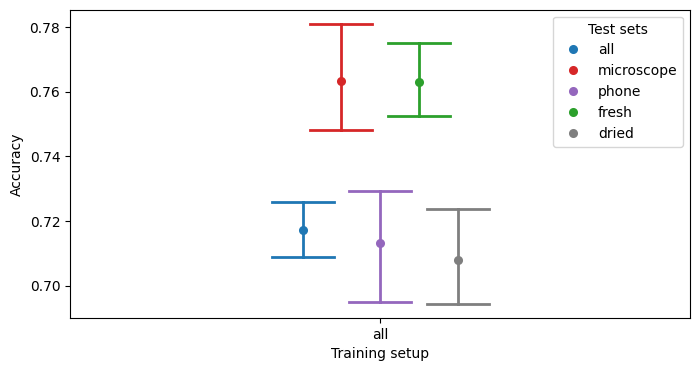

In [197]:
metrics = ["accuracy"]

relevant_subsets = ["all"]
relevant_evals = ["all", "fresh", "dried", "phone", "microscope"]


filtered = df[
(df["subset_name"].isin(relevant_subsets)) &
(df["eval_subset"].isin(relevant_evals))
]

for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.pointplot(
        data=filtered,
        x="subset_name",
        y=metric,
        hue="eval_subset",
        palette=color_palette,
        errorbar=('ci', 95),
        capsize=0.1,
        estimator="mean",
        linestyle='none',
        dodge=0.25,
        linewidth=2
    )
    plt.ylabel(metric.capitalize())
    plt.xlabel("Training setup")
    plt.legend(title="Test sets")
    plt.show()

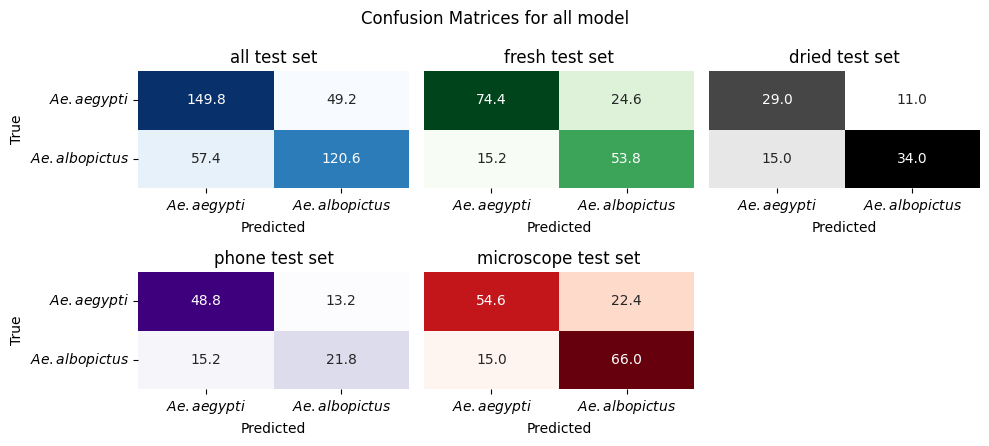

In [153]:
cm_results = {}

relevant_subsets = ["all"]
relevant_evals = ["all", "fresh", "dried", "phone", "microscope"]


filtered = df[
(df["subset_name"].isin(relevant_subsets)) &
(df["eval_subset"].isin(relevant_evals))
]

for (subset, evalset), group in filtered.groupby(["subset_name", "eval_subset"]):
    matrices = np.stack(group["confusion_matrix"].values)
    mean_cm = matrices.mean(axis=0)
    cm_results[(subset, evalset)] = mean_cm

for subset in filtered["subset_name"].unique():
    fig, axes = plt.subplots(2, 3, figsize=(10, 4.5))
    axes = axes.flatten()
    for i, evalset in enumerate(relevant_evals):
        cm = cm_results.get((subset, evalset))
        if cm is None:
            continue
        ax = axes[i]
        sns.heatmap(
            cm,
            annot=True,
            fmt=".1f",
            cmap=color_maps[evalset],
            cbar=False,
            xticklabels=["$Ae. aegypti$", "$Ae. albopictus$"],
            yticklabels=["$Ae. aegypti$", "$Ae. albopictus$"] if i % 3 == 0 else False,
            ax=ax
        )
        ax.set_title(f"{evalset} test set")
        ax.set_xlabel("Predicted")
        if i % 3 == 0:
            ax.set_ylabel("True")
        else:
            ax.set_ylabel("")
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
        if i % 3 == 0:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")
    
    if len(relevant_evals) < len(axes):
        for j in range(len(relevant_evals), len(axes)):
            fig.delaxes(axes[j])
    
    plt.suptitle(f"Confusion Matrices for {subset} model")
    plt.tight_layout()
    plt.show()


In [ ]:
relevant_model = ["all"]
relevant_evals = ["all", "fresh", "dried", "phone", "microscope"]
metrics = ["accuracy"]

filtered = df[
(df["subset_name"].isin(relevant_subsets)) &
(df["eval_subset"].isin(relevant_evals))
]

summary_results = []
pairwise_results = []

for metric in metrics:
    for subset in relevant_model:
        subset_data = filtered[filtered["subset_name"] == subset]
        
        normal_flags = {}
        groups = {}
        normal_p = {}
        for evalset in relevant_evals:
            values = subset_data[subset_data["eval_subset"] == evalset][metric].dropna().values
            groups[evalset] = values
            if len(values) >= 3:
                stat, p = stats.shapiro(values)
                normal_flags[evalset] = p > 0.05                
            else:
                normal_flags[evalset] = False
            normal_p[evalset] = p
        
        all_normal = all(normal_flags.values())
        
        if all_normal:
            f_stat, p_overall = stats.f_oneway(*groups.values())
            test = "ANOVA"
        else:
            h_stat, p_overall = stats.kruskal(*groups.values())
            test = "Kruskal"
        
        for evalset, values in groups.items():
            n = len(values)
            mean = np.mean(values)
            sem = stats.sem(values) if n > 1 else 0
            ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=sem) if n > 1 else (mean, mean)
            plusminus = ci_high - mean
            summary_results.append({
                "metric": metric,
                "model": subset,
                "eval_subset": evalset,
                "n": n,
                "mean": mean,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "plusminus": plusminus,
                "normal_p": normal_p[evalset],
                "normal_dist": normal_flags[evalset],
                "test": test,
                "overall_p": p_overall,
                "significant_overall": p_overall < 0.05
            })
        
        for g1, g2 in combinations(relevant_evals, 2):
            v1, v2 = groups[g1], groups[g2]
            if all_normal:
                t_stat, p_value = stats.ttest_ind(v1, v2)
                pair_test = "T-test"
            else:
                u_stat, p_value = stats.mannwhitneyu(v1, v2, alternative="two-sided")
                pair_test = "WithneyU"
            pairwise_results.append({
                "metric": metric,
                "model": subset,
                "pair_test": pair_test,
                "pair": f"{g1} vs {g2}",
                "p_value": p_value,
                "significant_pair": p_value < 0.05,
                "normal_dist": all_normal
            })


summary_df = pd.DataFrame(summary_results)
pairwise_df = pd.DataFrame(pairwise_results)
summary_df

,metric,model,eval_subset,n,mean,ci_low,ci_high,plusminus,normal_p,normal_dist,test,overall_p,significant_overall
0,accuracy,all,all,5,0.717241,0.703944,0.730538,0.013297,0.424328,True,ANOVA,0.000044,True
1,accuracy,all,fresh,5,0.763095,0.744692,0.781498,0.018403,0.384181,True,ANOVA,0.000044,True
2,accuracy,all,dried,5,0.707865,0.685806,0.729924,0.022059,0.967174,True,ANOVA,0.000044,True
3,accuracy,all,phone,5,0.713131,0.684257,0.742005,0.028874,0.685296,True,ANOVA,0.000044,True
4,accuracy,all,microscope,5,0.763291,0.736874,0.789708,0.026417,0.559671,True,ANOVA,0.000044,True


In [194]:
pairwise_df

,metric,model,pair_test,pair,p_value,significant_pair,normal_dist
0,accuracy,all,T-test,all vs fresh,0.000506,True,True
1,accuracy,all,T-test,all vs dried,0.341745,False,True
2,accuracy,all,T-test,all vs phone,0.728903,False,True
3,accuracy,all,T-test,all vs microscope,0.002536,True,True
4,accuracy,all,T-test,fresh vs dried,0.000696,True,True
5,accuracy,all,T-test,fresh vs phone,0.003677,True,True
6,accuracy,all,T-test,fresh vs microscope,0.986935,False,True
7,accuracy,all,T-test,dried vs phone,0.697936,False,True
8,accuracy,all,T-test,dried vs microscope,0.002079,True,True
9,accuracy,all,T-test,phone vs microscope,0.007416,True,True
